In [1]:
import sys
import pandas as pd
import time as time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import math
from matplotlib.lines import Line2D
import numba
import scienceplots
plt.style.use('science')

# Load data

In [2]:
run_path = 'processed_data/long_run_4mbar_500V/r57/'

In [3]:
# Main detectors
dssd = pd.read_csv(run_path + 'dssd_non_vetoed_events.csv') # non-vetoed, calibrated dssd events 
ppac = pd.read_csv(run_path + 'ppac_events.csv') # raw, uncalibrated
ruth = pd.read_csv(run_path + 'rutherford_events.csv')

# DSSD regions
imp = dssd[dssd['event_type'] == 'imp']
boxE = dssd[dssd['event_type'] == 'boxE']
boxW = dssd[dssd['event_type'] == 'boxW']
boxT = dssd[dssd['event_type'] == 'boxT']
boxB = dssd[dssd['event_type'] == 'boxB']

# Rutherfords
ruth_E = ruth[ruth['detector'] == 'ruthE']
ruth_W = ruth[ruth['detector'] == 'ruthW']

In [4]:
ruth_E_cut = ruth_E[ruth_E['energy'] > 8000]

# Recoil events

In [5]:
recoil_energy_min = 1000
recoil_energy_max = 8000

imp_df = imp[(imp['xE']>= recoil_energy_min) & (imp['xE'] <= recoil_energy_max)]

In [6]:
imp_df.head()

,t,x,y,tagx,tagy,nfile,xboard,yboard,tdelta,nX,nY,xE,yE,event_type
24,0.437129,18,43,437128517746,437128502744,0,5,6,15002,1,1,2159.544628,2141.916831,imp
26,0.591121,0,52,591121256185,591121227623,0,5,7,28562,1,1,4870.290764,4813.325856,imp
27,0.603669,37,19,603669458744,603669428374,0,4,6,30370,1,1,4773.726841,4756.903371,imp
54,0.853364,85,19,853363708867,853363648993,0,2,6,59874,2,1,1682.107595,1895.165465,imp
55,0.853364,85,20,853363708867,853363639493,0,2,7,69374,2,1,1682.107595,1895.165465,imp


# Decay events

In [7]:
# Set decay time window
min_corr_time = 0.00000001     # Minimum time after recoil to consider (in seconds)
max_corr_time = 1.53 * 6     # Maximum time after recoil to consider (in seconds)

In [8]:
# Build pixel history from the imp df & group the full implant event history by pixel (x,y)
pixel_groups = imp.groupby(['x', 'y'])
pixel_history = {pixel: group for pixel, group in pixel_groups}

In [9]:
# Create decay event list
decay_events = []

In [10]:
# For each recoil event, search for subsequent events in the same pixel from imp

# Create decay events list to hold events
decay_candidates = []  

# Loop through coincident imp (recoil-like) events
for recoil_idx, recoil in imp_df.iterrows():
    
    # Get the pixel for the recoil event
    pixel = (recoil['x'], recoil['y'])
    
    # Convert the recoil imp_timetag from picoseconds to seconds
    recoil_time_sec = recoil['tagx'] / 1e12
    
    # Check if there are any events in the same pixel in the imp region df.
    if pixel not in pixel_history:
        continue  # Skip if no events are found for this pixel
    
    # Get the time sorted events for this pixel from imp
    pixel_df = pixel_history[pixel]
    
    # Get the pixel time values as a sorted array
    time_array = pixel_df['t'].values # This is in seconds
    
    # Define the lower and upper bounds for candidate decay events in seconds
    lower_bound = recoil_time_sec + min_corr_time
    upper_bound = recoil_time_sec + max_corr_time
    
    # Use binary search to find the index positions in the time array
    start_idx = np.searchsorted(time_array, lower_bound, side='left')
    end_idx = np.searchsorted(time_array, upper_bound, side='right')
    
    # If events exist in the correlation window, add them as candidate decay events
    if start_idx < end_idx:
        
        candidate_events = pixel_df.iloc[start_idx:end_idx].copy()
        
        # Record the associated recoil info for later
        candidate_events['recoil_index'] = recoil_idx 
        candidate_events['recoil_time_sec'] = recoil_time_sec
        decay_candidates.append(candidate_events) # add decay candidates to list

# Combine all candidate decay events into a single df
if decay_candidates:
    decay_candidates_df = pd.concat(decay_candidates, ignore_index=True)
else:
    decay_candidates_df = pd.DataFrame()

# Display the first few decay candidates
print(decay_candidates_df.head())


          t   x   y           tagx           tagy  nfile  xboard  yboard  \
0  0.437129  18  43   437128517746   437128502744      0       5       6   
1  0.853364  85  19   853363708867   853363648993      0       2       6   
2  0.853364  85  20   853363708867   853363639493      0       2       7   
3  5.099507  48  11  5099507419996  5099507424004      0       5       6   
4  1.345875  47  29  1345874945374  1345874936006      0       4       6   

   tdelta  nX  nY           xE           yE event_type  recoil_index  \
0   15002   1   1  2159.544628  2141.916831        imp            24   
1   59874   2   1  1682.107595  1895.165465        imp            54   
2   69374   2   1  1682.107595  1895.165465        imp            55   
3   -4008   1   1   398.420928   409.813600        imp            76   
4    9368   1   1  1658.401112  1675.924549        imp            92   

   recoil_time_sec  
0         0.437129  
1         0.853364  
2         0.853364  
3         1.106931  
4    

# Decay KHS

In [11]:
# Find the log time between implant and decay event
decay_candidates_df['log_dt'] = np.log(abs(decay_candidates_df['t'] - decay_candidates_df['recoil_time_sec']))

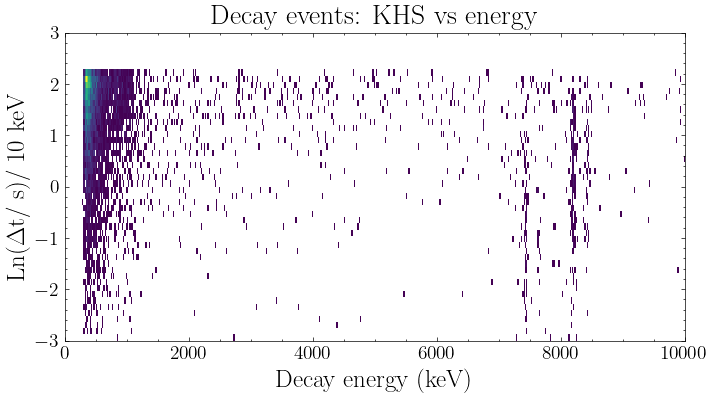

In [12]:
# Plot the 2d KHS hist
fs = 18
plt.figure(figsize=(8,4))
plt.hist2d(decay_candidates_df['yE'], decay_candidates_df['log_dt'], 
           bins=((500),(50)), range=((0,10000),(-3,3)), cmin=1)
plt.xlabel('Decay energy (keV)', fontsize=fs)
plt.ylabel(r'Ln($\Delta$t/ s)/ 10 keV', fontsize=fs)
plt.title('Decay events: KHS vs energy', fontsize=fs+2)
ax = plt.gca()
ax.tick_params(axis='both', labelsize=fs-4)
plt.savefig('plots/decay_khs.pdf', dpi=1000)

# EVR-a correlations

In [13]:
# Alpha energy, time gates
# Recoil energy gates

alpha_energy_min = 8170    # Minimum alpha energy (keV)
alpha_energy_max = 8300    # Maximum alpha energy (keV)

recoil_energy_min = 1000   # Minimum recoil energy (keV)
recoil_energy_max = 8100  # Maximum recoil energy (keV) 

alpha_corr_min = 0.000000001    # Minimum time difference in seconds 
alpha_corr_max = 1.53 * 10       # Maximum time difference in seconds


In [14]:
# Filter alpha candidates by energy
filtered_alpha_candidates = decay_candidates_df[
    (decay_candidates_df['xE'] >= alpha_energy_min) & 
    (decay_candidates_df['xE'] <= alpha_energy_max)
].copy()


In [15]:
# just making sure we have t
if 't' not in filtered_alpha_candidates.columns:
    filtered_alpha_candidates['t'] = filtered_alpha_candidates['timetag'] / 1e12 

## Square strategy

In [16]:
# Add columns to store correlation info
filtered_alpha_candidates['closest_recoil_index'] = np.nan
filtered_alpha_candidates['recoil_time'] = np.nan
filtered_alpha_candidates['time_difference'] = np.nan
filtered_alpha_candidates['recoil_energy'] = np.nan
filtered_alpha_candidates['correlated_pixel_x'] = np.nan
filtered_alpha_candidates['correlated_pixel_y'] = np.nan
filtered_alpha_candidates['is_same_pixel'] = False

# Loop through the alpha candidates
for idx, alpha in filtered_alpha_candidates.iterrows():
    alpha_x = alpha['x']
    alpha_y = alpha['y']
    alpha_time = alpha['t']
    
    # Define all pixels to check (current pixel + 8 neighbors)
    pixels_to_check = []
    for dx in [-1, 0, 1]:
        for dy in [-1, 0, 1]:
            neighbor_x = alpha_x + dx
            neighbor_y = alpha_y + dy
            if (neighbor_x, neighbor_y) in pixel_history:
                pixels_to_check.append((neighbor_x, neighbor_y))
    
    # Variables to track the closest recoil
    min_time_diff = float('inf')
    best_match = None
    best_pixel = None
    
    # Check all pixels for a potential recoil
    for pixel in pixels_to_check:
        pixel_x, pixel_y = pixel
        
        # Find recoils in this pixel
        recoils_in_pixel = imp_df[
            (imp_df['x'] == pixel_x) & 
            (imp_df['y'] == pixel_y)
        ]
        
        # Filter for recoils before the alpha and within time window
        if not recoils_in_pixel.empty:
            recoils_before = recoils_in_pixel[recoils_in_pixel['t'] < alpha_time].copy()
            
            if not recoils_before.empty:
                recoils_before['time_diff'] = alpha_time - recoils_before['t']
                
                # Apply correlation time window
                recoils_in_window = recoils_before[
                    (recoils_before['time_diff'] >= alpha_corr_min) &
                    (recoils_before['time_diff'] <= alpha_corr_max) &
                    (recoils_before['xE'] >= recoil_energy_min) &
                    (recoils_before['xE'] <= recoil_energy_max)
                ]
                
                if not recoils_in_window.empty:
                    # Find the closest recoil in this pixel
                    closest_idx = recoils_in_window['time_diff'].idxmin()
                    closest_recoil = recoils_in_window.loc[closest_idx]
                    
                    # If this is closer than any previously found recoil, update best match
                    if closest_recoil['time_diff'] < min_time_diff:
                        min_time_diff = closest_recoil['time_diff']
                        best_match = closest_recoil
                        best_pixel = pixel
    
    # Store the results if a correlation was found
    if best_match is not None:
        filtered_alpha_candidates.at[idx, 'closest_recoil_index'] = best_match.name
        filtered_alpha_candidates.at[idx, 'recoil_time'] = best_match['t']
        filtered_alpha_candidates.at[idx, 'time_difference'] = min_time_diff
        filtered_alpha_candidates.at[idx, 'recoil_energy'] = best_match['xE']
        filtered_alpha_candidates.at[idx, 'correlated_pixel_x'] = best_pixel[0]
        filtered_alpha_candidates.at[idx, 'correlated_pixel_y'] = best_pixel[1]
        filtered_alpha_candidates.at[idx, 'is_same_pixel'] = (best_pixel[0] == alpha_x and best_pixel[1] == alpha_y)

# Get all correlated events
correlated_events = filtered_alpha_candidates.dropna(subset=['closest_recoil_index'])

# Count same-pixel vs neighboring-pixel correlations
same_pixel_count = correlated_events['is_same_pixel'].sum()
neighbor_pixel_count = len(correlated_events) - same_pixel_count

print(f"Total correlated events: {len(correlated_events)}")
print(f"Same pixel correlations: {same_pixel_count} ({same_pixel_count/len(correlated_events)*100:.1f}%)")
print(f"Neighboring pixel correlations: {neighbor_pixel_count} ({neighbor_pixel_count/len(correlated_events)*100:.1f}%)")

# If there are neighboring-pixel correlations, look at the patterns
if neighbor_pixel_count > 0:
    neighbor_correlations = correlated_events[~correlated_events['is_same_pixel']].copy()
    
    # Calculate offsets
    neighbor_correlations['dx'] = neighbor_correlations['correlated_pixel_x'] - neighbor_correlations['x']
    neighbor_correlations['dy'] = neighbor_correlations['correlated_pixel_y'] - neighbor_correlations['y']
    
    # Count patterns
    pattern_counts = neighbor_correlations.groupby(['dx', 'dy']).size().reset_index(name='count')
    print("\nNeighboring pixel correlation patterns:")
    print(pattern_counts.sort_values('count', ascending=False))


Total correlated events: 265
Same pixel correlations: 224 (84.5%)
Neighboring pixel correlations: 41 (15.5%)

Neighboring pixel correlation patterns:
    dx   dy  count
2  0.0 -1.0     37
0 -1.0 -1.0      1
1 -1.0  1.0      1
3  1.0 -1.0      1
4  1.0  0.0      1


In [17]:
# Build the correlation df
correlated_events = filtered_alpha_candidates.dropna(subset=['recoil_time']).copy()
print("Number of correlated alpha-recoil events:", len(correlated_events))
print(correlated_events.head())

Number of correlated alpha-recoil events: 265
               t   x   y             tagx             tagy  nfile  xboard  \
95     30.667522  43   8   30667521818591   30667521770211      0       4   
838   232.338689  90   9  232338688874093  232338688822183      0       3   
1366  366.730860  34   8  366730860230213  366730860197935      1       5   
1448  388.048902  80  51  388048901981931  388048901926462      1       3   
1449  388.048902  80  52  388048901981931  388048901908059      1       3   

      yboard  tdelta  nX  ...  recoil_index  recoil_time_sec    log_dt  \
95         7   48380   1  ...          1760        26.374283  1.457042   
838        6   51910   1  ...         15622       231.276918  0.059939   
1366       7   32278   1  ...         25313       366.072135 -0.417449   
1448       6   55469   2  ...         26501       383.304354  1.556996   
1449       7   73872   2  ...         26502       383.304354  1.556996   

     closest_recoil_index  recoil_time  time_d

In [18]:
# Merge the recoil and alpha info together, and rename things for clarity
recoil_rename = {
    'imp_timetag': 'rec_timetag',
    'imp_x': 'rec_x',
    'imp_y': 'rec_y',
    'imp_tagx': 'rec_tagx',
    'imp_tagy': 'rec_tagy',
    'imp_nfile': 'rec_nfile',
    'imp_tdelta': 'rec_tdelta',
    'imp_nX': 'rec_nX',
    'imp_nY': 'rec_nY',
    'imp_xE': 'rec_xE',
    'imp_yE': 'rec_yE',
    'xboard': 'rec_xboard',
    'yboard': 'rec_yboard',
    't': 'rec_t',
    'dt_anodeH_us_corr': 'rec_dt_anodeH_us_corr',
    'dt_anodeV_us_corr': 'rec_dt_anodeV_us_corr',
    'dt_cathode_us_corr': 'rec_dt_cathode_us_corr'
}

alpha_rename = {
    't': 'alpha_t',
    'x': 'alpha_x',
    'y': 'alpha_y',
    'tagx': 'alpha_tagx',
    'tagy': 'alpha_tagy',
    'nfile': 'alpha_nfile',
    'xboard': 'alpha_xboard',
    'yboard': 'alpha_yboard',
    'tdelta': 'alpha_tdelta',
    'nX': 'alpha_nX',
    'nY': 'alpha_nY',
    'xE': 'alpha_xE',
    'yE': 'alpha_yE',
    'event_type': 'alpha_event_type',
    'recoil_index': 'alpha_recoil_index',
    'recoil_time_sec': 'alpha_recoil_time',
    'ppac_flag': 'alpha_ppac_flag',
    'is_clean': 'alpha_is_clean',
    'log_dt': 'alpha_log_dt',
    # Also include new computed cols
    'closest_recoil_index': 'alpha_closest_recoil_index',
    'recoil_time': 'alpha_recoil_time_calculated',
    'time_difference': 'alpha_time_difference',
    'recoil_energy': 'alpha_recoil_energy'
}

# Rename columns in the recoil df
recoil_df_renamed = imp_df.copy().rename(columns=recoil_rename)

# Rename columns in the alpha df
alpha_df_renamed = correlated_events.copy().rename(columns=alpha_rename)


# Merge the two dfs using the recoil index
final_correlated_df = alpha_df_renamed.merge(
    recoil_df_renamed,
    left_on='alpha_recoil_index',
    right_index=True,
    how='inner'
)


In [19]:
# print some check stuff
# print("Final correlated Events df:")
# print(final_correlated_df.head())
# print("Checking pixel matches (alpha vs. recoil):")
# print(final_correlated_df[['alpha_x', 'alpha_y', 'rec_x', 'rec_y']].head())
# print(f"NUMBER OF CORRELATIONS = {len(final_correlated_df)}")

# Plotting correlated stuff

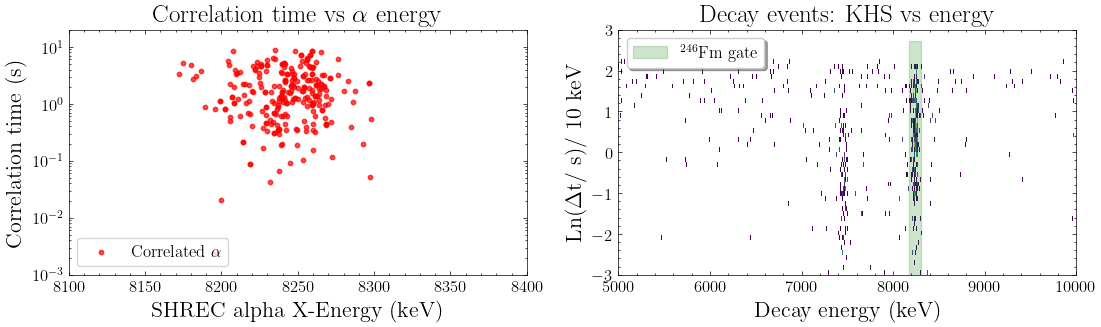

In [20]:
# # log decay time

final_correlated_df['log_dt'] = np.log10(np.abs(final_correlated_df['alpha_t'] - final_correlated_df['rec_t']))
final_correlated_df['rec_alpha_time'] =np.abs(final_correlated_df['alpha_t'] - final_correlated_df['rec_t'])
fs = 16
plt.figure(figsize=(13,7))

plt.subplot(221)
plt.scatter(final_correlated_df['alpha_xE'], final_correlated_df['rec_alpha_time'],
            s=10, color='red', alpha=0.7, label=r'Correlated $\alpha$')
plt.xlabel('SHREC alpha X-Energy (keV)', fontsize=fs)
# plt.ylabel(r'log(dt/s)', fontsize=fs)
plt.ylabel(r'Correlation time (s)', fontsize=fs)
plt.xlim(8100, 8400)
plt.yscale('log')
ax = plt.gca()
ax.tick_params(axis='both', labelsize=fs-4 )
plt.legend(fontsize=fs-4, loc='lower left', frameon=True)
plt.ylim(0.001,20)
plt.title(r'Correlation time vs $\alpha$ energy', fontsize=fs+2)

plt.subplot(222)
plt.hist2d(decay_candidates_df['xE'], decay_candidates_df['log_dt'], 
           bins=((500),(50)), range=((5000,10000),(-3,3)), cmin=1)
plt.fill_betweenx(y=[np.log(alpha_corr_min), np.log(alpha_corr_max)], x1=alpha_energy_min, x2=alpha_energy_max, 
                  color='g', alpha=0.2, label=r'$^{246}$Fm gate')
plt.xlabel('Decay energy (keV)', fontsize=fs)
plt.ylabel(r'Ln($\Delta$t/ s)/ 10 keV', fontsize=fs)
plt.title('Decay events: KHS vs energy', fontsize=fs+2)
ax = plt.gca()
ax.tick_params(axis='both', labelsize=fs-4)
plt.legend(fontsize=fs-4, loc='upper left', frameon=True, facecolor='white', shadow=True)




# plt.savefig('plots/log_time_corr_alphas.pdf', dpi=300)

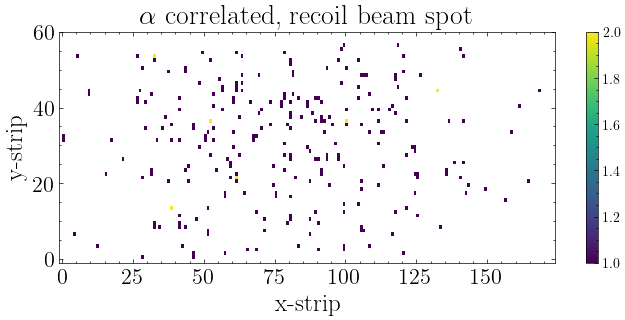

In [33]:
# # correlated beam spot
plt.figure(figsize=(8,3))
fs = 18
# plt.subplots(221)
plt.hist2d(final_correlated_df['x'], final_correlated_df['y'], 
           bins=((175),(61)), range=((-1,174),(-1,60)), cmin=1)
# plt.xlim(0, 10000)
plt.xlabel('x-strip', fontsize=fs)
plt.ylabel(r'y-strip', fontsize=fs)
plt.title(r'$\alpha$ correlated, recoil beam spot', fontsize=fs+2)
plt.colorbar()
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=fs-2)
# plt.legend(loc='lower right', fontsize=fs-2, frameon=True)

# plt.subplots(222)
# plt.hist2d(coincident_imp_df['imp_x'], coincident_imp_df['imp_y'], 
#            bins=((175),(61)), range=((-1,174),(-1,60)), cmin=1)
# # plt.xlim(0, 10000)
# plt.xlabel('x-strip', fontsize=fs)
# plt.ylabel(r'y-strip', fontsize=fs)
# plt.title(r'Uncorrelated recoil beam spot', fontsize=fs+2)
# plt.colorbar()
# ax = plt.gca()
# ax.tick_params(axis='both', which='major', labelsize=fs-2)

plt.savefig('plots/correlated_stripX_stripY.pdf', dpi=300)

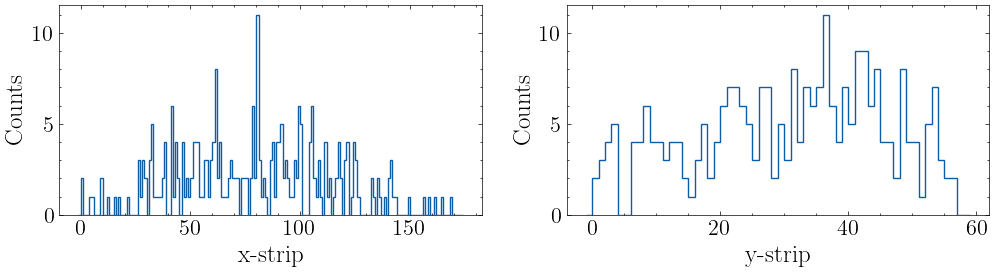

In [22]:
# beam spot projections
# correlated beam spot

plt.figure(figsize=(12,6))
fs = 18

plt.subplot(221)
plt.hist(final_correlated_df['x'], histtype='step', bins=175, range=(-1,174))
plt.xlabel('x-strip', fontsize=fs)
plt.ylabel(r'Counts', fontsize=fs)
# plt.title(r'$\alpha$ correlated, recoil beam spot', fontsize=fs+2)
# plt.colorbar()
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=fs-2)

plt.subplot(222)
plt.hist(final_correlated_df['y'], histtype='step',bins=60, range=(-1,59))
plt.xlabel('y-strip', fontsize=fs)
plt.ylabel(r'Counts', fontsize=fs)
# plt.title(r'$\alpha$ correlated, recoil beam spot', fontsize=fs+2)
# plt.colorbar()
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=fs-2)


plt.savefig('plots/correlated_beam_spot_projections.pdf', dpi=300)

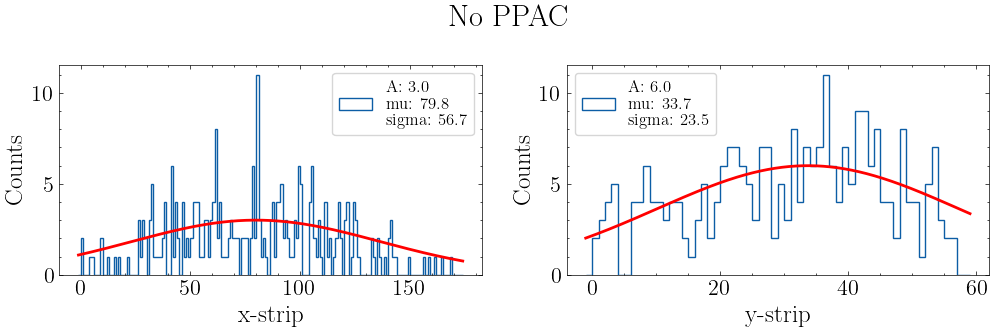

In [31]:
from scipy.optimize import curve_fit

# Define Gaussian function
def gaussian(x, amplitude, mean, sigma):
    return amplitude * np.exp(-(x - mean)**2 / (2 * sigma**2))

# Plotting with Gaussian fits
plt.figure(figsize=(12, 6))
fs = 18

# X projection (subplot 1)
plt.subplot(221)
hist_data_x, bin_edges_x, _ = plt.hist(final_correlated_df['x'], histtype='step', 
                                      bins=175, range=(-1, 174))
bin_centers_x = (bin_edges_x[:-1] + bin_edges_x[1:]) / 2

# Only use bins with non-zero counts for fitting
mask_x = hist_data_x > 0
x_fit = bin_centers_x[mask_x]
y_fit = hist_data_x[mask_x]

# Initial guess: [amplitude, mean, sigma]
p0_x = [np.max(y_fit), np.mean(final_correlated_df['x']), np.std(final_correlated_df['x'])]

try:
    # Fit Gaussian to the histogram data
    popt_x, pcov_x = curve_fit(gaussian, x_fit, y_fit, p0=p0_x)
    
    # Generate points for the fitted curve
    x_curve = np.linspace(-1, 174, 1000)
    y_curve = gaussian(x_curve, *popt_x)
    
    # Plot the fitted curve
    plt.plot(x_curve, y_curve, 'r-', linewidth=2)
    
    # Add legend with fit parameters
    plt.legend([f'A: {popt_x[0]:.1f}\nmu: {popt_x[1]:.1f}\nsigma: {popt_x[2]:.1f}'], 
              fontsize=fs-6, frameon=True)
except Exception as e:
    print(f"X-fit error: {e}")

plt.xlabel('x-strip', fontsize=fs)
plt.ylabel(r'Counts', fontsize=fs)
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=fs-2)

# Y projection (subplot 2)
plt.subplot(222)
hist_data_y, bin_edges_y, _ = plt.hist(final_correlated_df['y'], histtype='step', 
                                      bins=60, range=(-1, 59))
bin_centers_y = (bin_edges_y[:-1] + bin_edges_y[1:]) / 2

# Only use bins with non-zero counts for fitting
mask_y = hist_data_y > 0
y_fit_x = bin_centers_y[mask_y]  # x values for fitting
y_fit_y = hist_data_y[mask_y]    # y values for fitting

# Initial guess: [amplitude, mean, sigma]
p0_y = [np.max(y_fit_y), np.mean(final_correlated_df['y']), np.std(final_correlated_df['y'])]

try:
    # Fit Gaussian to the histogram data
    popt_y, pcov_y = curve_fit(gaussian, y_fit_x, y_fit_y, p0=p0_y)
    
    # Generate points for the fitted curve
    y_curve_x = np.linspace(-1, 59, 1000)
    y_curve_y = gaussian(y_curve_x, *popt_y)
    
    # Plot the fitted curve
    plt.plot(y_curve_x, y_curve_y, 'r-', linewidth=2)
    
    # Add legend with fit parameters
    plt.legend([f'A: {popt_y[0]:.1f}\nmu: {popt_y[1]:.1f}\nsigma: {popt_y[2]:.1f}'], 
              fontsize=fs-6, frameon=True)
except Exception as e:
    print(f"Y-fit error: {e}")

plt.suptitle('No PPAC', fontsize=fs+4, y=0.98)
plt.xlabel('y-strip', fontsize=fs)
plt.ylabel(r'Counts', fontsize=fs)
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=fs-2)


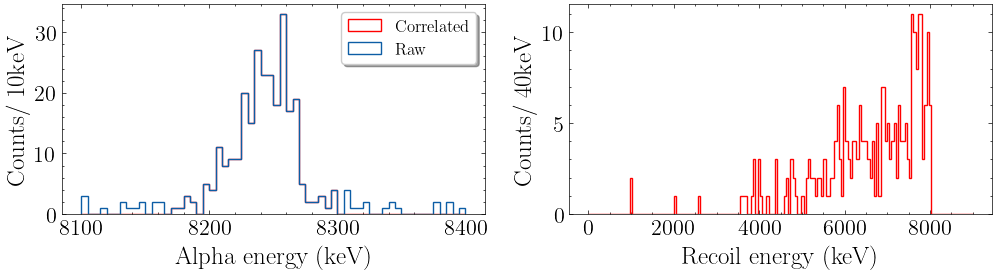

In [24]:
# Recoil and alpha energies

plt.figure(figsize=(12,6))
fs = 18

plt.subplot(221)
plt.hist(final_correlated_df['alpha_xE'], histtype='step', color='r', bins=60, range=(8100,8400), label='Correlated')
plt.hist(decay_candidates_df['xE'], histtype='step', bins=60, range=(8100,8400), label='Raw')
plt.xlabel('Alpha energy (keV)', fontsize=fs)
plt.ylabel(r'Counts/ 10keV', fontsize=fs)
# plt.title(r'$\alpha$ correlated, recoil beam spot', fontsize=fs+2)
# plt.colorbar()
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=fs-2)
plt.legend(fontsize=fs-6, frameon=True, shadow=True)

plt.subplot(222)
plt.hist(final_correlated_df['xE'], histtype='step',bins=175, range=(0,9000), color='r')
# plt.hist(coincident_imp_df['im\p_xE'], histtype='step',bins=175, range=(0,9000))
plt.xlabel('Recoil energy (keV)', fontsize=fs)
plt.ylabel(r'Counts/ 40keV', fontsize=fs)
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=fs-2)
# ax.set_xlim(2000,8000)


plt.savefig('plots/rec_alpha_energy_projections.pdf', dpi=300)

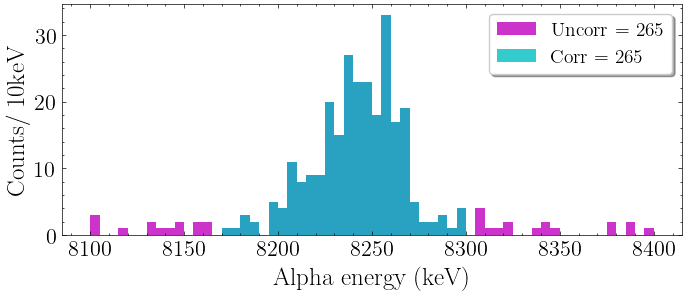

In [25]:
plt.figure(figsize=(8,3))
fs = 18
label_corr = f'Corr = {len(final_correlated_df)}'
len_uncorr_alphas = len(decay_candidates_df[
    (decay_candidates_df["xE"] >= alpha_energy_min) &
    (decay_candidates_df["xE"] <= alpha_energy_max)
]["xE"])
label_uncorr = f'Uncorr = {len_uncorr_alphas}'
plt.hist(decay_candidates_df['xE'], histtype='stepfilled', color='m',alpha=0.8, bins=60, range=(8100,8400), label=label_uncorr)
plt.hist(final_correlated_df['alpha_xE'], histtype='stepfilled', color='c', alpha=0.8, bins=60, range=(8100,8400), label=label_corr)
plt.xlabel('Alpha energy (keV)', fontsize=fs)
plt.ylabel(r'Counts/ 10keV', fontsize=fs)
# plt.title(r'$\alpha$ correlated, recoil beam spot', fontsize=fs+2)
# plt.colorbar()
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=fs-2)
plt.legend(fontsize=fs-4, frameon=True, shadow=True)
plt.savefig('plots/raw_vs_correlated_alphas.pdf', dpi=300)

In [27]:
# # Save the dfs
# coincident_imp_df.to_csv(f"{run_path}/coincident_imp.csv", index=False)
# final_correlated_df.to_csv(f"{run_path}/final_correlated.csv", index=False)
# decay_candidates_df.to_csv(f"{run_path}/decay_candidates.csv", index=False)
# non_coincident_imp_df.to_csv(f"{run_path}/non_coincident_imp.csv", index=False)

In [28]:
# calculate number of evr-a events per 1k rutherfords
# 1. Get the total number of correlated EVR-alpha events
n_evr_alpha = len(final_correlated_df)

# 2. Get the total number of Rutherford events
n_rutherford = len(ruth_E_cut)  
# 3. Calculate EVR-alpha events per 1000 Rutherford events
evr_per_1k_ruth = (n_evr_alpha / n_rutherford) * 1000

print(f"EVR-alpha events: {n_evr_alpha}")
print(f"Rutherford events: {n_rutherford}")
print(f"EVR-alpha events per 1000 Rutherford events: {evr_per_1k_ruth:.2f}")

EVR-alpha events: 265
Rutherford events: 204493
EVR-alpha events per 1000 Rutherford events: 1.30


Peak region: 8172-8298 keV
Correlated counts in peak: 265
Uncorrelated counts in peak: 265
Background-subtracted counts in peak: 244.41666666666666
Ratio (corr/uncorr): 1.000
Ratio (corr/bkg-subtracted): 1.084


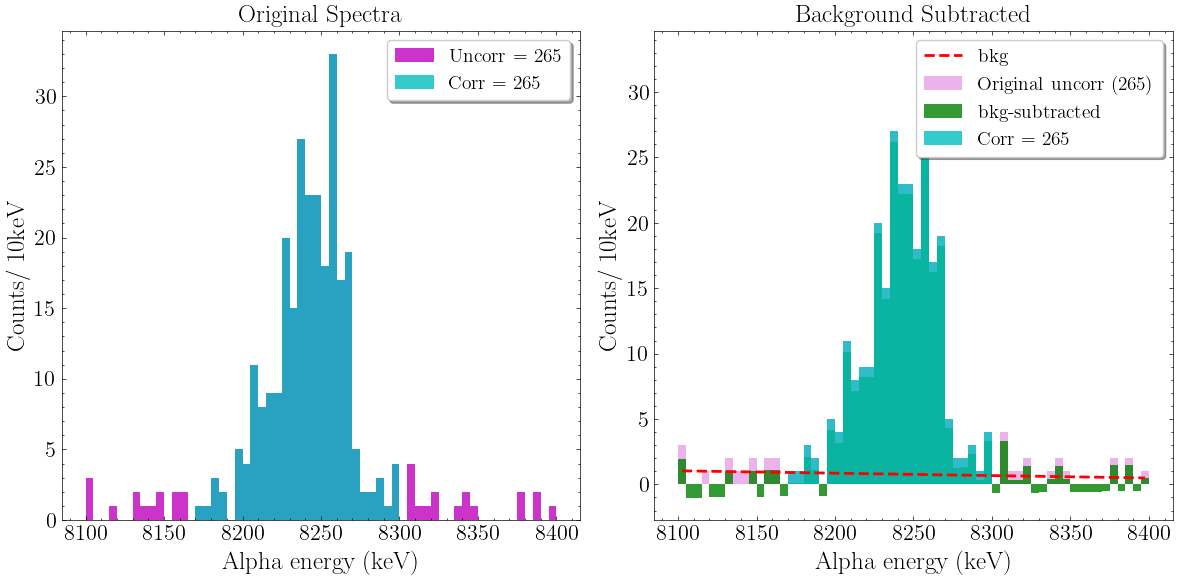

In [29]:

plt.figure(figsize=(12,6))
plt.subplot(121)
label_corr = f'Corr = {len(final_correlated_df)}'
len_uncorr_alphas = len(decay_candidates_df[
    (decay_candidates_df["xE"] >= alpha_energy_min) &
    (decay_candidates_df["xE"] <= alpha_energy_max)
]["xE"])
label_uncorr = f'Uncorr = {len_uncorr_alphas}'

hist_uncorr, bin_edges = np.histogram(
    decay_candidates_df['xE'], 
    bins=60, 
    range=(8100,8400)
)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

plt.hist(decay_candidates_df['xE'], histtype='stepfilled', color='m', alpha=0.8, 
         bins=60, range=(8100,8400), label=label_uncorr)
plt.hist(final_correlated_df['alpha_xE'], histtype='stepfilled', color='c', alpha=0.8, 
         bins=60, range=(8100,8400), label=label_corr)

plt.xlabel('Alpha energy (keV)', fontsize=fs)
plt.ylabel(r'Counts/ 10keV', fontsize=fs)
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=fs-2)
plt.legend(fontsize=fs-4, frameon=True, shadow=True)
plt.title("Original Spectra", fontsize=fs)

###########################################################
# Bkg sub plot 
plt.subplot(122)

# Ddefine bkg regions
bkg_region1 = (8100, 8170)  
bkg_region2 = (8350, 8400)  

# get bkg points & use mask
bkg_mask = ((bin_centers >= bkg_region1[0]) & (bin_centers <= bkg_region1[1])) | \
           ((bin_centers >= bkg_region2[0]) & (bin_centers <= bkg_region2[1]))
bkg_x = bin_centers[bkg_mask]
bkg_y = hist_uncorr[bkg_mask]

# linear background
m, c, r_value, p_value, std_err = stats.linregress(bkg_x, bkg_y)
background = m * bin_centers + c
background = np.maximum(background, 0)

# bkg sub
hist_subtracted = hist_uncorr - background

# Plot the original uncorrelated data
plt.bar(bin_centers, hist_uncorr, width=5, alpha=0.3, color='m', 
        label=f'Original uncorr ({len_uncorr_alphas})')

plt.plot(bin_centers, background, 'r--', lw=2, label='bkg')

plt.bar(bin_centers, hist_subtracted, width=5, alpha=0.8, color='g', 
        label='bkg-subtracted')

hist_corr, _ = np.histogram(final_correlated_df['alpha_xE'], bins=60, range=(8100,8400))
plt.bar(bin_centers, hist_corr, width=5, alpha=0.8, color='c', 
        label=label_corr)

plt.xlabel('Alpha energy (keV)', fontsize=fs)
plt.ylabel(r'Counts/ 10keV', fontsize=fs)
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=fs-2)
plt.legend(fontsize=fs-4, frameon=True, shadow=True)
plt.title("Background Subtracted", fontsize=fs)

peak_min_idx = np.searchsorted(bin_centers, alpha_energy_min)  # Find bin index for 8200 keV
peak_max_idx = np.searchsorted(bin_centers, alpha_energy_max)  # Find bin index for 8300 keV

# Calculate the ratio in the peak region
corr_peak_sum = np.sum(hist_corr[peak_min_idx:peak_max_idx])
uncorr_peak_sum = np.sum(hist_uncorr[peak_min_idx:peak_max_idx])
bkg_subtracted_sum = np.sum(hist_subtracted[peak_min_idx:peak_max_idx])

# Print the ratios
print(f'Peak region: {bin_centers[peak_min_idx]:.0f}-{bin_centers[peak_max_idx-1]:.0f} keV')
print(f'Correlated counts in peak: {corr_peak_sum}')
print(f'Uncorrelated counts in peak: {uncorr_peak_sum}')
print(f'Background-subtracted counts in peak: {bkg_subtracted_sum}')
print(f'Ratio (corr/uncorr): {corr_peak_sum/uncorr_peak_sum:.3f}')
print(f'Ratio (corr/bkg-subtracted): {corr_peak_sum/bkg_subtracted_sum:.3f}')
plt.tight_layout()
plt.savefig('plots/background_subtracted_alphas.pdf', dpi=300)